In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

sns.set(style="whitegrid")


In [2]:
# Path to raw CFPB dataset
RAW_PATH = Path("../data/raw/cfpb_complaints.csv")

# Load data
df = pd.read_csv(RAW_PATH)

print("Dataset shape:", df.shape)
df.head()


C:\Users\yam\AppData\Local\Temp\ipykernel_15600\48103435.py:5: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_PATH)


Dataset shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [3]:
df.columns


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

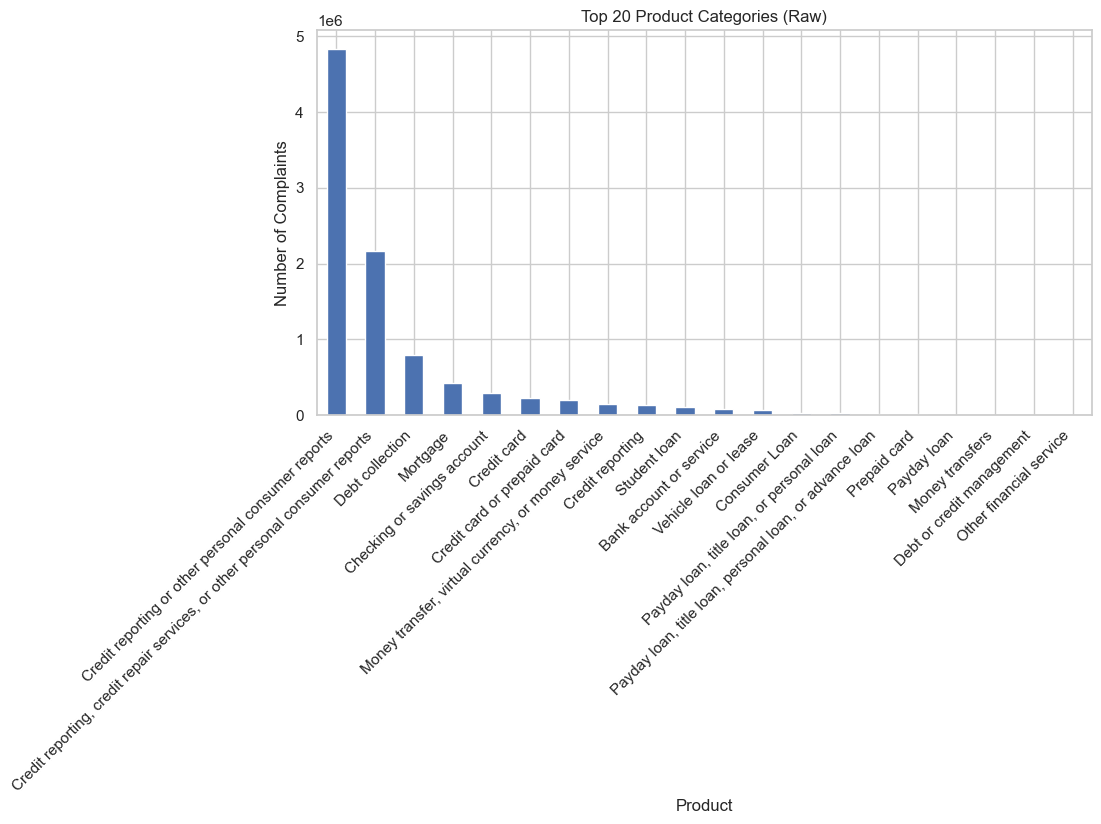

In [4]:
plt.figure(figsize=(10,5))
df["Product"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Product Categories (Raw)")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45, ha="right")
plt.show()


In [5]:
total = len(df)
missing = df["Consumer complaint narrative"].isna().sum()

print(f"Total complaints: {total}")
print(f"Complaints with missing narratives: {missing}")
print(f"Complaints with narratives: {total - missing}")


Total complaints: 9609797
Complaints with missing narratives: 6629041
Complaints with narratives: 2980756


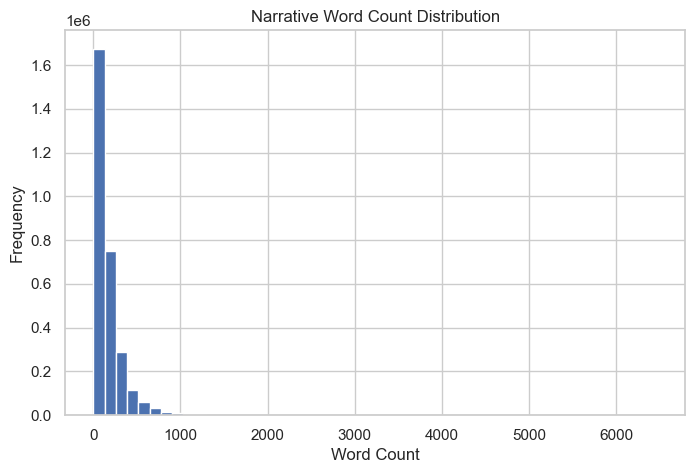

In [6]:
narratives = df["Consumer complaint narrative"].dropna().astype(str)
word_counts = narratives.apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(word_counts, bins=50)
plt.title("Narrative Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [7]:
PRODUCT_KEYWORDS = {
    "Credit Cards": ["credit card"],
    "Personal Loans": ["personal loan"],
    "Savings Accounts": ["savings account", "savings"],
    "Money Transfers": ["money transfer", "remittance", "wire transfer"]
}

def map_product_category(product):
    if not isinstance(product, str):
        return None
    p = product.lower()
    for category, keywords in PRODUCT_KEYWORDS.items():
        if any(k in p for k in keywords):
            return category
    return None

df["product_category"] = df["Product"].apply(map_product_category)

# Keep only selected categories
df = df[df["product_category"].notna()]

print("After product filtering:", df.shape)
df["product_category"].value_counts()


After product filtering: (921808, 19)


product_category
Credit Cards        433055
Savings Accounts    291178
Money Transfers     150420
Personal Loans       47155
Name: count, dtype: int64

In [8]:
df["Consumer complaint narrative"] = (
    df["Consumer complaint narrative"]
    .fillna("")
    .astype(str)
)

df = df[df["Consumer complaint narrative"].str.strip() != ""]

print("After removing empty narratives:", df.shape)


After removing empty narratives: (454472, 19)


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i am writing to file a complaint.*", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_narrative"] = df["Consumer complaint narrative"].apply(clean_text)

# Drop rows that became empty after cleaning
df = df[df["clean_narrative"].str.strip() != ""]

print("After cleaning:", df.shape)


After cleaning: (449859, 20)


In [10]:
df[[
    "Complaint ID",
    "product_category",
    "Product",
    "clean_narrative"
]].head()


,Complaint ID,product_category,Product,clean_narrative
12237,14069121,Credit Cards,Credit card,a xxxx xxxx card was opened under my name by a...
12532,14061897,Savings Accounts,Checking or savings account,i made the mistake of using my wellsfargo debi...
13280,14047085,Credit Cards,Credit card,dear cfpb i have a secured credit card with ci...
13506,14040217,Credit Cards,Credit card,i have a citi rewards cards the credit balance...
13955,13968411,Credit Cards,Credit card,b i am writing to dispute the following charge...


In [11]:
OUTPUT_PATH = Path("../data/filtered_complaints.csv")
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

df_out = df[[
    "Complaint ID",
    "product_category",
    "Product",
    "clean_narrative"
]].rename(columns={
    "Complaint ID": "complaint_id",
    "Product": "product"
})

df_out.to_csv(OUTPUT_PATH, index=False)

print("Saved cleaned dataset to:", OUTPUT_PATH)
print("Final shape:", df_out.shape)


Saved cleaned dataset to: ..\data\filtered_complaints.csv
Final shape: (449859, 4)
